# Spectral Gap Superposition States via Adiabatic Thermalization

The estimation of the spectral gap, 
defined as the energy difference between the ground state 
and the first excited state of a quantum system, 
is fundamental in both condensed matter physics
and quantum chemistry.

Unfortunately most of the Quantum Computing schemes
remain out of reach since we are 
currently living 
in the so-called Noisy Intermediate-Scale Quantum (NISQ) era,
in which actual devices are made 
of a limited number of noisy qubits.
In this notebook, 
we showcase how to apply a novel approach 
for estimating the spectral gap in quantum systems. 
We define the Spectral Gap Superposition(SGS) state as

$$
\ket{SGS(0,1)} = \frac{1}{\sqrt{2}}\left(\ket{\Omega_0}  + \ket{\Omega_1} \right),
$$

where $\ket{\Omega_0}$ and $\ket{\Omega_1}$
respectively are the groundstate and the first excited state
of the system Hamiltonian $H$.

The procedure can be schematized as follows: A Quantum Circuit prepares the Spectral Gap Superposition
State (SGS) through Adiabatic Thermalization. Then, sequential measurements of the chosen observable $O(t)$ at different time
steps are conducted, followed by a fitting procedure to determine the spectral gap. The obtained value is compared to the
benchmark spectral gap.
![scheme](scheme.png)

In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
from pennylane import qchem
np.random.seed(1)

We'll start by getting all the relevant information to upload a molecule from the pennylane dataset section. Information on molecules can be found here: https://pennylane.ai/datasets/

# Molecular Hamiltonian Pre Processing

### Load Molecule Hamiltonian

In [85]:
# mol_name = 'H2'
# bond_length = 0.742
# basis = 'STO-3G'

mol_name = 'He2'
bond_length = 5.2
basis = '6-31G'

In [86]:
mol = qml.data.load("qchem", molname=mol_name, bondlength=bond_length, basis=basis)

### Analytically find ground and first excited state eigenvalues and eigenvectors of Hamiltonian(NOT NECCESARY!)

In [87]:
from pennylane import qchem

def eig_sort (w, v):
    '''
    Returns 2 lists containing the eigenvalues and eigenvectors sorted in ascending order of the eigenvalue
    Args:
        w (np.array(float)): A vector containing the eigenvalues of a matrix
        v (np.array(np.array(float))): A vector containing the eigenvectors of a matrix
    Returns:
        np.array(int), np.array(np.array(float)), ordered vectors
    '''
    W = []
    V = []
    ind = np.argsort(w)
    for i in range(0, len(w)):
        W.append(w[ind[i]])
        V.append(v.T[ind[i]])
    return np.array(W),np.array(V).T

def Hamiltonian_ground_excited():
    '''
    Calculates the spectrum of the 1D TFIM Hamiltonian. 
    And return grounds and excited states.

    Args:
        num_qubits (int): The number of qubits / spins.
        h (float): The transverse field strength.

    Returns:
        (tuple): grounds, exciteds states, eigenvalues
    '''
    H = dict(mol[0].attrs)['hamiltonian'].get_value()
    n_qubits = len(dict(mol[0].attrs)['hamiltonian'].get_value().wires)
    print("Number of qubits: {:}".format(n_qubits))
    print("Qubit Hamiltonian")
    print(H)
    coefficients = H.coeffs
    H_terms = H.ops
    
    val,vec = np.linalg.eig(qml.matrix(H))
    val,vec = eig_sort(val,vec)    

    # finding all possible degenerates ground states
    ground_idxs = np.where(np.isclose(val,val[0], atol=1e-1))
    grounds = vec.T[ground_idxs]
    
    # finding all possible degenerates first excited states
    exc_idxs = np.where(np.isclose(val,val[np.max(ground_idxs)+1], atol=1e-1))
    
    excs = vec.T[exc_idxs]
        
    return n_qubits, coefficients,H_terms, grounds, excs, val 

In [88]:
n_qubits, coef, H_terms ,grounds, excs, eigenvals = Hamiltonian_ground_excited()
spectral_gap = (eigenvals[1]-eigenvals[0]).real
print(eigenvals[:6], (eigenvals[1]-eigenvals[0]).real)

Number of qubits: 8
Qubit Hamiltonian
  (-1.6743100655776795) [I0]
+ (-0.51937337612909) [Z6]
+ (-0.51937337612909) [Z7]
+ (-0.5193693204313439) [Z5]
+ (-0.5193693204313438) [Z4]
+ (0.34164083116202126) [Z3]
+ (0.3416408311620214) [Z2]
+ (0.34164129511099833) [Z0]
+ (0.3416412951109985) [Z1]
+ (0.025441159889825968) [Z4 Z6]
+ (0.025441159889825968) [Z5 Z7]
+ (0.025441159889832365) [Z0 Z2]
+ (0.025441159889832365) [Z1 Z3]
+ (0.09152839641299161) [Z0 Z4]
+ (0.09152839641299161) [Z1 Z5]
+ (0.09152840853436708) [Z2 Z4]
+ (0.09152840853436708) [Z3 Z5]
+ (0.09152846114785738) [Z0 Z6]
+ (0.09152846114785738) [Z1 Z7]
+ (0.0915284732694976) [Z2 Z6]
+ (0.0915284732694976) [Z3 Z7]
+ (0.10851592748044003) [Z6 Z7]
+ (0.10851594197255018) [Z4 Z7]
+ (0.10851594197255018) [Z5 Z6]
+ (0.10851595646504474) [Z4 Z5]
+ (0.11998719451969339) [Z0 Z7]
+ (0.11998719451969339) [Z1 Z6]
+ (0.1199872161024396) [Z0 Z5]
+ (0.1199872161024396) [Z1 Z4]
+ (0.11998727739702426) [Z2 Z7]
+ (0.11998727739702426) [Z3 Z6]
+ (

### Save on separate list the diagonal terms of Hamiltonian

In [89]:
obs = []
coef_0 = []

for i in range(len(coef)):
    pstring = qml.pauli.pauli_word_to_string(H_terms[i])
    if 'X' in pstring or 'Y' in pstring or 'I' in pstring:
        pass
    else:
        obs.append(H_terms[i])
        coef_0.append(coef[i])

### Create diagonal Hamiltonian and save its ground state and first excited state

In [109]:
H_0 = qml.Hamiltonian(coef_0, obs)

val_0,vec_0 = np.linalg.eig(qml.matrix(H_0))
val_0,vec_0 = eig_sort(val_0,vec_0)    

# finding all possible degenerates ground states
ground_idxs_0 = np.where(np.isclose(val_0,val_0[0], atol=1e-1))
grounds_0 = vec_0.T[ground_idxs_0]
exc_idxs_0 = np.where(np.isclose(val_0,val_0[np.max(ground_idxs_0)+1], atol=1e-1))
excs_0 = vec_0.T[exc_idxs_0]





def occup_to_compbasis(x):
    '''
    Given the vector with only 1 non zero element, it will return the index of that element

    Args:
        x(np.array(int)): Vector with only 1 non zero element 
    Returns:
        r(int): index of non zero element
    '''
    r = 0
    for i in range(len(x)):
        r += x[i]*i
    r = int(np.real(r))
    return r



print(val_0[:6], (val_0[1]-val_0[0]).real  )
print('\n')
print(grounds_0[0])
print(excs_0[0])
print('\n')
O_string = str(bin(occup_to_compbasis(grounds_0[0]) ^ occup_to_compbasis(excs_0[0]))[2:].zfill(n_qubits))
print(O_string)
O_real = ''
for i in range(len(O_string)):
    if O_string[i] == '0':
        O_real += 'I'
    else:
        O_real += 'X'

O_real = qml.pauli.string_to_pauli_word(O_real)
O_real

[-4.03601079+0.j -3.12188464+0.j -3.12188464+0.j -3.12188368+0.j
 -3.12188368+0.j -2.63615562+0.j] 0.9141261466665918


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j

PauliX(wires=[3])

### Define thermalization and time evolution steps variables.

In [91]:
#THERMALIZATION VARIABLES
delta_tau = 0.3
# tau = 7.8
tau_steps = 5#thermalization steps

#TIME EVOLUTION VARIABLES
t_steps = 30 # time evolution steps
delta_t = 0.4


# Create Trotterization Circuits

### Helper Functions

In [92]:
def create_string(i):
    '''
    Given an index i, returns the according Pauli String.
    Args:
        i (int): 
    Returns:
        string_pauli (str): A Pauli String
    '''
    string_pauli = ''
    i_new = int(np.base_repr(i, 4))
    for k in range(n_qubits):
            the_monster = int(str(int(np.floor(i_new*10**(k-n_qubits + 1))))[-1])%4
            if the_monster == 0:
                string_pauli += 'I'
            elif the_monster == 1:
                string_pauli += 'X'
            elif the_monster == 2:
                string_pauli += 'Y'
            elif the_monster == 3:
                string_pauli += 'Z'
    return string_pauli

def write_op_list(op_list, mol_name, bond_length, basis):
    '''
    Given a list containing the operations to implement a 
    Trotter step for a particular molecule, bond length and basis
    creates a file with the information in the list:

    Args:
        op_list (list): List of operations for trotter step
        mol_name (str): Molecule name
        bond_length (float): length of bond
        basis (str): Molecule basis
    '''
    fname = f'{mol_name}_{bond_length}_{basis}_operations.txt'
    with open(fname, 'w') as f:
        for op in op_list:
            for el in op:
                f.write(str(el))
                f.write(';')
            f.write('\n')

### Trotter circuit operations generator

In [93]:
def trotter_step_operation_list(H_terms, n_qubits):
    '''
    
    Args:
        H_terms (list): List of pennylane.ops that form hamiltonian for a particular molecule 
        n_qubits (int): Number of Qubits
    
    Returns:
        op_list (list), List of operations to implement a trotter step for the Hamiltonian
    '''
    op_list = []

    try:
        fname = f'/data/{mol_name}_{bond_length}_{basis}_operations.txt'

        with open(fname, 'r') as f:
            for i in f.readlines():
                op_str = i.split(';')
                if op_str[0] == 'CNOT':
                    op_list.append([op_str[0], str(op_str[1]), [int(op_str[2][1]), int(op_str[2][4])], op_str[3]])
                else:
                    op_list.append([op_str[0], float(op_str[1]), int(op_str[2]), op_str[3]])
    except:
        for j in range(len(coef)):
            for i in range(1,4**n_qubits):
                string_pauli = create_string(i)
                
                if qml.pauli.pauli_word_to_string(H_terms[j], wire_map=range(n_qubits)) == string_pauli:
                    
                    occupation = []
                    for idx in range(len(string_pauli)):
                        if string_pauli[idx] == 'I':
                            pass
                        else:
                            occupation.append(idx)

                    for idx in range(len(string_pauli)):
                        if string_pauli[idx] == 'X':
                            op_list.append(['RY', -np.pi/2, idx, 'N/A'])
                        elif string_pauli[idx] == 'Y':
                            op_list.append(['RX', np.pi/2, idx, 'N/A'])
                    
                    for cnot_idx in range(len(occupation) - 1):
                        op_list.append(['CNOT', 'N/A', [occupation[cnot_idx], occupation[cnot_idx + 1]], 'N/A'])
                    
                    if 'X' in string_pauli or 'Y' in string_pauli:
                        op_list.append(['RZ', -2*coef[j], occupation[-1], 'delta_t*s'])
                    else:
                        op_list.append(['RZ', -2*coef[j], occupation[-1], 'delta_t'])

                    for cnot_idx in range(len(occupation) - 2, -1, -1):
                        op_list.append(['CNOT', 'N/A', [occupation[cnot_idx], occupation[cnot_idx + 1]], 'N/A'])
                    
                    for idx in range(len(string_pauli)):
                        if string_pauli[idx] == 'X':
                            op_list.append(['RY', np.pi/2, idx, 'N/A'])

                        elif string_pauli[idx] == 'Y':
                            op_list.append(['RX', -np.pi/2, idx, 'N/A'])
        write_op_list(op_list, mol_name, bond_length, basis)
    return op_list

### Application of Trotter step

In [94]:
def apply_op_list(op_list, s, delta_t = 0.3):
    '''
    Creates pennylane circuit for trotter step implementation.

    Args:
        op_list (list): List of operations for trotter step
        s(float): Switching on terms(swtiches on the off-diagonal part of the hamiltoanian)
        delta_t(float): Time step of Adiabatic Thermalization
    '''
    for op in op_list:
        if op[0] == 'RZ':
            if op[3] == 'delta_t*s':
                qml.RZ(op[1]*delta_t*s, wires=op[2])
            elif op[3] == 'delta_t':
                qml.RZ(op[1]*delta_t, wires=op[2])
        elif op[0] == 'CNOT':
            qml.CNOT(op[2])
        elif op[0] == 'RX':
            qml.RX(op[1], wires=op[2])
        elif op[0] == 'RY':
            qml.RY(op[1], wires=op[2])
    
op_list = trotter_step_operation_list(H_terms, n_qubits)

# Circuits

### Helper Functions

In [95]:
def fidelity(a,b):
    '''
    Given 2 state vectors, returns the fidelity
    Args:
        a(list(float)): a state vector
        b(list(float)): a state vector
    
    Returns:
        float, fidelity between a and b
    '''
    return abs(np.vdot(np.array(a, dtype = 'complex128'),np.array(b, dtype = 'complex128')))**2               
def overlap(a,b):
    ''' 
    Given 2 state vectors, returns the overlap
    Args:
        a(list(float)): a state vector
        b(list(float)): a state vector
    
    Returns:
        float, overlap between a and b
    '''
    return np.vdot(np.array(a, dtype = 'complex128'),np.array(b, dtype = 'complex128'))

### Adiabatic Thermalization

In [96]:
device = qml.device("lightning.qubit", wires=n_qubits, shots=8192)


def SGS_circ(tau_steps=10, delta_tau = 0.3):
    '''
    Circuit responsible for the preparation of the SGS state via Adiabatic Thermalization
    
    Args:
        tau_steps(int): Number of Trotter steps for Adiabatic thermalization
        delta_tau(float): Time step size during Adiabatic Thermalization
    '''
    thermalization_steps = np.linspace(0, 1, tau_steps+2)[1:-1]#first and last do not affect
    #state preparation
    #########
    # preparing the initial SGS 

    ground_and_excs = occup_to_compbasis(excs_0[0])& occup_to_compbasis(grounds_0[0])
    for i in range(n_qubits):
        if ground_and_excs & 2**(n_qubits-1-i) != 0:
            qml.PauliX(i)

    ground_xor_excs = occup_to_compbasis(excs_0[0])^ occup_to_compbasis(grounds_0[0])
    counter = 0
    Had_pos = 0
    for i in range(n_qubits):
        if ground_xor_excs & 2**(n_qubits-1-i) != 0: 
            if counter == 0:
                qml.Hadamard(i)
                if occup_to_compbasis(grounds_0[0]) & 2**(n_qubits-1-i) != 0:
                    a = occup_to_compbasis(grounds_0[0])
                else:
                    a = occup_to_compbasis(excs_0[0])
                counter = 1
                Had_pos = i
            else:
                if a & 2**(n_qubits-1-i) != 0:
                    qml.CNOT([Had_pos,i])
                else:
                    qml.CNOT([Had_pos,i])
                    qml.PauliX(i)

    for s in thermalization_steps:
        apply_op_list(op_list, s,delta_tau)

@qml.qnode(device)
def SGS_state(tau_steps=10, delta_tau = 0.3):
    '''
    Circuit returning the SGS state obtained via Adiabatic Thermalization
    
    Args:
        tau_steps(int): Number of Trotter steps for Adiabatic thermalization
        delta_tau(float): Time step size during Adiabatic Thermalization
    Returns:
        qml.state(), state of circuit after Adiabatic Thermalization to create SGS
    '''
    SGS_circ(tau_steps, delta_tau)

    return qml.state()

In [97]:
# qml.draw_mpl(SGS_circ, decimals=2, wire_order=range(n_qubits))(tau_steps=1)

In [98]:
statevec = SGS_state(tau_steps=tau_steps, delta_tau=delta_tau)

print('{:.3f},{:.3f},{:.3f},{:.3f}'.format(fidelity(grounds[0], statevec), fidelity(excs[0], statevec), fidelity(excs[1], statevec), fidelity(excs[2], statevec)))
print(statevec)

0.499,0.000,0.486,0.000
[-1.13341420e-16+1.87936473e-17j -1.22711189e-16-7.39965468e-17j
 -9.17307813e-17+5.80747679e-18j -2.23228922e-17-1.39573877e-17j
 -4.39438927e-18-4.84225708e-17j -2.90722610e-18-4.57425231e-19j
 -2.79689280e-17-1.49535984e-17j -7.38055538e-18+1.77305939e-17j
  2.02173179e-17+2.91116386e-17j  1.59486285e-17-9.12915258e-18j
  5.00444446e-18-7.83318229e-18j -3.09327669e-18-1.67556423e-17j
 -5.63365704e-18-1.32648681e-17j -9.56381210e-18+1.09623585e-17j
 -8.41606900e-03-1.55126282e-03j  1.92411590e-03-1.99654201e-03j
  9.90255342e-18-2.31083381e-16j  1.33681006e-16+1.28816519e-16j
  2.97676918e-17-4.43566414e-17j  1.28641971e-17-3.20191670e-19j
  4.52179616e-17-3.64014478e-17j -1.23393380e-17+2.22052902e-18j
 -6.18955272e-17-6.78773556e-18j  1.09817141e-17-1.22133037e-17j
 -7.49630158e-18+9.56194747e-17j  3.59108305e-17-1.45027940e-17j
 -2.53610527e-18-3.83896069e-18j -3.08499292e-18-1.14627637e-17j
 -1.58479140e-19+2.82002084e-17j -6.20419844e-18-1.10584889e-17j
 

/home/ubuntu/.local/lib/python3.10/site-packages/pennylane/_qubit_device.py:653: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


To have better fitting we will employ Chebyshev timesteps in the time evolution process

In [ ]:
def convert_string_to_observable(string):
    

### Time Evolution

In [99]:
def chebyshev_time(t_steps, delta_t):
    '''
    Returns Chebyshev nodes as time to help improve fitting accuracy
    
    Args:
        t_steps(int): Number of Trotter steps in time evolution
        delta_t(float): Time step during time evolution
    
    Returns:
        n_nodes (list), List containing the Chebyshev nodes
    '''

    n_nodes = []
    
    for t in range(t_steps):
        n_nodes.append(t_steps*delta_t*(0.5*np.cos(np.pi*(t_steps-1-t)/(t_steps-1))+0.5))

    return n_nodes

def time_evolution(t_steps=10, step=0, delta_t = 0.3):
    ''' 
    Circuit for the time evolution of the SGS state.

    Args:
        t_steps(int): Number of Trotter steps in time evolution
        step(int): How many steps of time evolution to perform
        delta_t(float): Time step size during time evolution
    '''
    times = chebyshev_time(t_steps, delta_t)

    for i,t in enumerate(times[:step]):
        if i==0:
            dt=t
        else:
            dt = t - times[i-1]
        apply_op_list(op_list, 1, dt)

# Energy Gap estimation with SGS

In [110]:
device = qml.device("lightning.qubit", wires=n_qubits, shots=8192,)

@qml.qnode(device)
def evol_SGS_expval(tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3, O= O_real):
    '''
    Circuit returning the expectation value of time evoluted Z_0 on the SGS state obtained via Adiabatic Thermalization
    
    Args:
        tau_steps(int): Number of Trotter steps for Adiabatic thermalization
        t_steps(int): Number of Trotter steps in time evolution
        step(int): How many steps of time evolution to perform
        delta_tau(float): Time step size during Adiabatic Thermalization
        delta_t(float): Time step size during time evolution
        O(qml.operator): Observable who's expectation value will be taken

    Returns:
        qml.count(O), counts of obervable O
    '''
    SGS_circ(tau_steps, delta_tau)
    time_evolution(t_steps,step, delta_t)

    return qml.counts(op = O, )

@qml.qnode(device,interface='jax')
def evol_SGS_state(tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3,):
    '''
    Circuit returning the SGS state obtained via Adiabatic Thermalization and then time evoluted
    
    Args:
        tau_steps(int): Number of Trotter steps for Adiabatic thermalization
        t_steps(int): Number of Trotter steps in time evolution
        step(int):
        delta_tau(float): Time step size during Adiabatic Thermalization
        delta_t(float): Time step size during time evolution
    
    Returns:
        qml.state(), state of circuit after Adiabatic Thermalization to create SGS and to evolve in time
    '''
    SGS_circ(tau_steps, delta_tau, )
    time_evolution(t_steps, step, delta_t)
    return qml.state()

Again we check that the SGS state is approximately an equal superposition of the ground and the excited state during the time evolution

In [111]:
for t in range(t_steps):
    statevec = evol_SGS_state(tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
    print(t, '{:.3f},{:.3f}'.format(fidelity(grounds[0], statevec), fidelity(excs[0], statevec)))

/home/ubuntu/.local/lib/python3.10/site-packages/pennylane/_qubit_device.py:653: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


0 0.499,0.000
1 0.499,0.000
2 0.499,0.000
3 0.498,0.000
4 0.499,0.000
5 0.499,0.000
6 0.499,0.000
7 0.497,0.000
8 0.494,0.000
9 0.495,0.000
10 0.497,0.000
11 0.492,0.000
12 0.491,0.000
13 0.495,0.000
14 0.490,0.000
15 0.491,0.000
16 0.494,0.000
17 0.489,0.000
18 0.492,0.000
19 0.494,0.000
20 0.491,0.000
21 0.494,0.000
22 0.497,0.000
23 0.495,0.000
24 0.495,0.000
25 0.496,0.000
26 0.498,0.000
27 0.499,0.000
28 0.499,0.000
29 0.500,0.000


And now we are ready to compute the expectation value at different time steps:

In [112]:
vals = []
errors = []
for t in range(t_steps):
    expval=0
    counts = evol_SGS_expval(tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
    shots = counts[1]+counts[-1]
    p_0 = counts[1]/shots
    p_1 = counts[-1]/shots
    expval = (p_1*(-1)+ p_0)
    err = np.sqrt(4*p_0*p_1/(shots-1))# /
    errors.append(err)
    vals.append(expval)
    if t%5==0:
        print(t, f'{expval:.3f}, {err:.3f}')

0 0.207, 0.011
5 -0.245, 0.011
10 -0.863, 0.006
15 0.981, 0.002
20 -0.886, 0.005
25 -0.038, 0.011


# Fitting

In the end we fit the points with a `cosine` function. The spectral gap will be given by
$$\Delta E = \frac{2\pi}{T}$$
where $T$ is the period of the oscillating function.

Numerical: 0.87654
Estimated: 0.86321+/-0.0081567
Reltive error: 0.015208370127338675


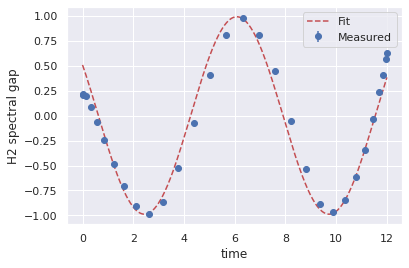

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.optimize import curve_fit
#FITTING PROCESS

def prefitting_function (x,a,b,c,d):
    ''' 
    Returns a generic cosine

    Args:
        x(float): Angle of cosine
        a(float): Principal axis
        b(float): Amplitude
        c(float): Angular frequency
        d(float): Phase
    
    Returns:
       a + b*np.cos(c*x + d)
    '''
    f = a + b*np.cos(c*x + d)
    return f

x_axis =np.array(chebyshev_time(t_steps, delta_t))##np.linspace(0, t_steps*delta_t, t_steps)# 

omega = 0.6#2*np.pi/14.5

p, pcov = curve_fit(prefitting_function, x_axis , vals, sigma= np.array(errors),
                    p0 = [ 0., 1, omega, 0],)
                    

plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)
plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')

plt.xlabel("time")
plt.ylabel('H2 spectral gap')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



print(f'Numerical: {spectral_gap:.5f}')
estim_gap = np.abs(p[2])
print(f'Estimated: {estim_gap:.5f}+/-{np.sqrt(pcov[2][2]):.5g}')
relativ_err = np.abs(spectral_gap-p[2])/spectral_gap
print(f'Reltive error: {relativ_err}')
# plt.text(1.3,0.3, f'Spectral Gap\nNum: {spectral_gap:.3f}\nEstim: {estim_gap:.3f}+/-{pcov[2][2]:.3g}', 
        #  fontsize='medium', bbox=props, horizontalalignment='center')#, zorder=z)
# plt.grid()
plt.legend()
plt.show()